In [ ]:
# This file contains the general set up for customized image data loaded inspired from pytorch documentation 

In [4]:
# load packages
from __future__ import print_function, division
import os
import torch 
from skimage import io, transform  # scikit  images  # io: to read and write images, transform: transform and resize the images 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader # inherit Dataset and DataLoader classes from pytorch
from torchvision import transforms, utils # data processing
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


In [11]:
# about the data : faces that are annotated with landmarks 
# The data_set file faces  contains the images and  an annotation  csv file of the form image_name| landmarks 
csv_file = "D:/Deep_learning_essai_pytorch/Customized_data_set/Data_set/faces/faces/face_landmarks.csv"
root_dir = "D:/Deep_learning_essai_pytorch/Customized_data_set/Data_set/faces/faces"
landmarks_frame  = pd.read_csv(csv_file)

# see the n'th obseration 
n = 65
image_name = landmarks_frame.iloc[n,0] # image name 
landmarks = landmarks_frame.iloc[n,1:] # landmarks (x1, y1, x2, y2, ...) 
landmarks = np.asarray(landmarks)
landmarks= landmarks.astype('float').reshape(-1, 2)  # reshaping landmarks to take the form (x1,y1), (x2,y2), ...(xn,yn)
print('Image name : {}'.format(image_name))
print('Landmarks shape : {}'.format(landmarks.shape) )
print ('First 4 Landmarks: {} '.format(landmarks[:4]))

Image name : person-7.jpg
Landmarks shape : (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]] 


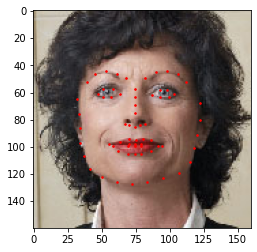

(160, 160, 3)


In [43]:
# helper function to show the image and the landmarks 
def show_landmarks (image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker = '.', c= 'r')
    plt.pause(0.001)  # pause a bit so that plots are updated
plt.figure()
image = io.imread(os.path.join(root_dir, image_name))
show_landmarks(image, landmarks)
print(image.shape)
plt.show()

In [14]:
# Pytorch data set class
#   from torch.utils.data.Dataset: an abstract class presenting the dataset 
# We should inherit this class and overrid the follwing methods:
# __len__() so that len(dataset) returns the size of the data set 
# __getitem__() that support the indexing so that dataset[i] returns the ith sample 
# The sample of the dataset will be the dictionary {'image': image, 'landmarks': landmarks}
# transforms will be an optional argument ( for data transformation purpose)


class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir 
        self.transform = transform 
    def __len__(self):
        return len(self.landmarks_frame )
    def __getitem__(self, idx):
        if torch.is_tensor(idx): # if the index sequence is a tensor, return it to a list
            idx = idx.tolist()
        image_name = self.landmarks_frame.iloc[idx, 0]
        image = io.imread(os.path.join(root_dir, image_name))
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample
        

0 (324, 215, 3) (68, 2)


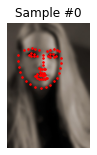

1 (500, 333, 3) (68, 2)


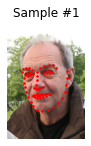

2 (250, 258, 3) (68, 2)


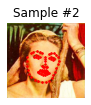

3 (434, 290, 3) (68, 2)


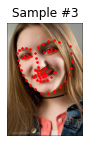

In [61]:
# try the FaceLandmarksDataset class
face_dataset = FaceLandmarksDataset(csv_file, root_dir)
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [47]:
# Transforms
# The images do not have the same size, most NN expect the same size
# to do this we need to create 3 preprocessing classes:
# Rescale : to scale the image 
# RandmCrop: to crop from image randomly (data augmentation)
# ToTensor :  to convert an numpy images to torch images 
# We will write them as callable classes instead of simple functions so that parameters of 
# the transform need not be passed everytime it’s called. For this, we just need to implement __call__ method 
# and if required, __init__ method. We can then use a transform like this:
# tsfm = Transform(params)
# transformed_sample = tsfm(sample)


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2] # hight and width (image.shape = (h,w , # RGB channels))
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size*h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size*w/h
        else:
            new_h, new_w = self.output_size 
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': image, 'landmarks': landmarks}
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size ):
        assert isinstance(output_size, (int, tuple))
        if isinstance (output_size, int ):
            self.output_size = output_size, output_size 
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    def __call__(self, sample):
        image, landmarks  = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size 
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w - new_w)
        image = image[top: top + new_h, left : left + new_w]
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}
    
class ToTensor (object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image), 'landmarks': torch.from_numpy(landmarks)}

            


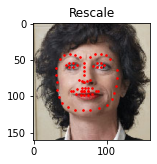

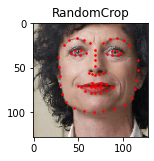

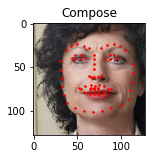

In [50]:
# Compose transform 
# Now, we apply the transforms on a sample.

# Let’s say we want to rescale the shorter side of the image to 150 and then randomly crop a square 
# of size 128 from it. i.e, we want to compose Rescale and RandomCrop transforms. 
# torchvision.transforms.Compose is a simple callable class which allows us to do this
scale = Rescale(150)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(150),
                               RandomCrop(128)])

# Apply these transformations on a sample:
figure = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate( [scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()


In [56]:
# iterating throught a transformed data set
transformed_dataset =  FaceLandmarksDataset(csv_file, root_dir, transform =  transforms.Compose([Rescale(150),
                               RandomCrop(128), ToTensor()]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(),sample['landmarks'].size() )
    if i==3:
        break
# problems with this iterating method :
# No Batching the data
# No Shuffling the data
# No Load the data in parallel using multiprocessing workers.

# Alternative : Using the DataLoader class from pytorch


0 torch.Size([128, 128, 3]) torch.Size([68, 2])
1 torch.Size([128, 128, 3]) torch.Size([68, 2])
2 torch.Size([128, 128, 3]) torch.Size([68, 2])
3 torch.Size([128, 128, 3]) torch.Size([68, 2])


In [57]:
dataloader = DataLoader(transformed_dataset, batch_size = 4, shuffle= True, num_workers = 0 )

In [60]:
for batch_idx, sample in enumerate(dataloader):
    print(sample['image'].size())
    print(sample['landmarks'].size())
    print(batch_idx)

torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
0
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
1
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
2
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
3
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
4
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
5
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
6
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
7
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
8
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
9
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
10
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
11
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
12
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
13
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
14
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
15
torch.Size([4, 128, 128, 3])
torch.Size([4, 68, 2])
16
torch.Size([1, 128, 128, 3])
torch.Size([1, 68, 2])
17
